## Data Wrangling

### Imports

In [1]:
# Fixes threadpoolctl to skip BLAS probing issues on Windows
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"]       = "1"
os.environ["MKL_NUM_THREADS"]       = "1"
import contextlib, threadpoolctl
def no_op_threadpool_limits(limits=None, user_api=None):
    return contextlib.nullcontext()
threadpoolctl.threadpool_limits = no_op_threadpool_limits

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (make_scorer, roc_auc_score, precision_recall_curve, f1_score,
                             precision_score, recall_score, average_precision_score)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore') # suppress warnings

### Read In & Inspect Data

In [3]:
df = pd.read_csv('creditcard.csv')

In [ ]:
df.head()

Note: Due to confidentiality limitations, PCA components are provided rather than original features (e.g., merchant category, card type, or location). While the PCA components keep variability intact, using them directly removes the need for proper feature engineering that would typically be done beforehand - this is a limitation of public use data.

## EDA

In [ ]:
df.info()

All values are numeric and there are no missing values. We have 28 PCA components, Time, Amount, and Class. The Time feature is the number of seconds that have elapsed between this transaction and the first transaction; with a max of 179792, this dataset encompasses 48 hours of transactions. The Amount feature is self-explanatory. And finally, Class is the binary target feature to signify fraud.

In [ ]:
df.describe().T

In [ ]:
# Check class imbalance
df['Class'].value_counts(normalize=True)

In [ ]:
# Check kernel density estimate plots by Class
fraud_df = df[df['Class'] == 1]
normal_df = df[df['Class'] == 0]

plt.figure(figsize=(16, 12))
for i in range(1, 29):
    plt.subplot(7, 4, i)
    sns.kdeplot(normal_df[f'V{i}'], label='Normal', fill=True)
    sns.kdeplot(fraud_df[f'V{i}'], label='Fraud', fill=True)
    plt.title(f'V{i}')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.legend()

These plots can be used to determine which PCA components are most influential in helping our model learn. Generally speaking, we are looking for plots without a lot of overlap.

In [ ]:
# Fraud per hour
df['Hour'] = (df['Time'] % 86400) // 3600

sns.countplot(data=df[df['Class'] == 1], x='Hour')
plt.xticks(rotation=45)
plt.title("Fraud Count by Hour of Day")

The highest frequencies were at 2 a.m. and 11 a.m.

In [ ]:
df['Amount'].describe()

There is a huge maximum value of 25691 while the mean is only 88 with std of 250. We will leave the outliers for now, but should adjust the limit for visualization purposes.

In [ ]:
sns.kdeplot(df[df['Class']==0]['Amount'], label='Normal', fill=True)
sns.kdeplot(df[df['Class']==1]['Amount'], label='Fraud', fill=True)
plt.xlim(0, 1000)  # Helps remove noise from huge outliers
plt.title("Amount Distribution")
plt.legend()

The distributions of Amount (presumably in Euros) by Class appear to be relatively similar, but with a notable spike in the lower end of the distribution for fraudulent charges.

In [ ]:
# Sample df
sample_df = df.sample(10000, random_state=42)
X = sample_df.drop(columns=['Class', 'Time']).astype('float64').values

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)

# Plot
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=sample_df['Class'],
    palette='Set1',
    alpha=0.6
)
plt.title("t-SNE Visualization of PCA Components")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Class')
plt.show()

## Preprocessing

In [5]:
# Define scorers
scoring = {
    'precision': 'precision',
    'recall': 'recall',    
    'f1': 'f1',
    'average_precision': 'average_precision'
}

# Define cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# X, y preparation
X = df.drop(columns='Class')
y = df['Class']

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Modeling

In [ ]:
# ======= STEP 1: Evaluation Function (Cross-Validation) ======= #
def evaluate_model(model, scale=True):
    steps = []
    if scale:
        steps.append(('scaler', StandardScaler()))
    
    steps += [('smote', SMOTE(random_state=42, n_jobs=7)), ('classifier', clone(model))]
    pipeline = Pipeline(steps)

    results = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, return_train_score=False)
    
    print(f"\n📊 Cross-Validation Results for {model.__class__.__name__}")
    for metric in scoring:
        mean = np.mean(results[f'test_{metric}'])
        std = np.std(results[f'test_{metric}'])
        print(f'{metric:<17}: {mean:.4f} ± {std:.4f}')

# ======= STEP 2: Threshold Tuning Function ======= #
def threshold_tuning(model, scale=True):
    print(f"\n🔍 Threshold Tuning for {model.__class__.__name__}")
    thresholds = np.arange(0.1, 0.91, 0.05)
    f1_scores = []
    recalls = []
    precisions = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        steps = []
        if scale:
            steps.append(('scaler', StandardScaler()))
        steps += [('smote', SMOTE(random_state=42, n_jobs=7)), ('classifier', clone(model))]
        pipeline = Pipeline(steps)
        pipeline.fit(X_train, y_train)

        probas = pipeline.predict_proba(X_test)[:, 1]

        for t in thresholds:
            preds = (probas >= t).astype(int)
            f1_scores.append(f1_score(y_test, preds))
            recalls.append(recall_score(y_test, preds))
            precisions.append(precision_score(y_test, preds))

    # Aggregate and plot
    mean_f1 = [np.mean(f1_scores[i::len(thresholds)]) for i in range(len(thresholds))]
    mean_rec = [np.mean(recalls[i::len(thresholds)]) for i in range(len(thresholds))]
    mean_prec = [np.mean(precisions[i::len(thresholds)]) for i in range(len(thresholds))]

    print(f"{'Threshold':<10} {'F1':<8} {'Recall':<8} {'Precision':<8}")
    for t, f, r, p in zip(thresholds, mean_f1, mean_rec, mean_prec):
        print(f"{t:<10.2f} {f:<8.4f} {r:<8.4f} {p:<8.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, mean_f1, label='F1 Score')
    plt.plot(thresholds, mean_rec, label='Recall')
    plt.plot(thresholds, mean_prec, label='Precision')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"{model.__class__.__name__} - Threshold Tuning")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Logistic Regression

In [ ]:
evaluate_model(LogisticRegression(solver='liblinear', class_weight='balanced', n_jobs=7, random_state=42))

### Random Forest

In [ ]:
rf =

In [ ]:
evaluate_model(RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=7, random_state=42),
               scale=False)

### XGBoost

In [ ]:
evaluate_model(XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss',
                             scale_pos_weight=(y==0).sum()/(y==1).sum(), n_jobs=7, random_state=42),
               scale=False)

### Multi-Layer Perceptron

In [ ]:
evaluate_model(MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42))

### Threshold Tuning for Best Models

In [ ]:
# Threshold Tuning
threshold_tuning(RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=7, random_state=42),
                 scale=False)
threshold_tuning(XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss',
                               scale_pos_weight=(y==0).sum()/(y==1).sum(), n_jobs=7, random_state=42),
                 scale=False)

In [ ]:
def compute_ks_and_threshold(y_true, y_score, target_capture_rate=0.9):
    df = pd.DataFrame({'y_true': y_true, 'y_score': y_score})
    df = df.sort_values('y_score', ascending=False).reset_index(drop=True)

    df['cum_total'] = np.arange(1, len(df)+1)
    df['cum_fraud'] = df['y_true'].cumsum()
    df['cum_nonfraud'] = df['cum_total'] - df['cum_fraud']

    total_fraud = df['y_true'].sum()
    total_nonfraud = len(df) - total_fraud

    df['cum_fraud_rate'] = df['cum_fraud']/total_fraud
    df['cum_nonfraud_rate'] = df['cum_nonfraud']/total_nonfraud
    df['ks_stat'] = df['cum_fraud_rate'] - df['cum_nonfraud_rate']

    ks_stat = df['ks_stat'].max()
    ks_idx = df['ks_stat'].idxmax()
    ks_threshold = df.loc[ks_idx, 'y_score']

    # Find smallest portion of sample that contains target_capture_rate (e.g. 90%) of frauds
    capture_idx = df[df['cum_fraud_rate'] >= target_capture_rate].index[0]
    capture_percent_of_data = (capture_idx + 1)/len(df)
    capture_threshold = df.loc[capture_idx, 'y_score']

    print(f'KS Statistic: {ks_stat:.4f} at threshold {ks_threshold:.4f}')
    print(f'To capture {target_capture_rate*100:.0f}% of frauds, analyze top \
        {capture_percent_of_data*100:.1f}% of data (threshold: {capture_threshold:.4f})')

    return {
        'ks_stat': ks_stat,
        'ks_threshold': ks_threshold,
        'capture_threshold': capture_threshold,
        'capture_percent_of_data': capture_percent_of_data
    }

**Placeholder text** Talk about which recall/precision trade-off is best to go with depending on the cost of false positives vs false negatives

## Temp code

In [7]:
# ======= STEP 1: Evaluation Function (CV on Training Data) ======= #
def evaluate_model(model, scale=True):
    steps = []
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps += [('smote', SMOTE(random_state=42, n_jobs=7)), ('classifier', clone(model))]
    
    pipeline = Pipeline(steps)
    results = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, return_train_score=False)
    
    print(f"\n📊 Cross-Validation Results for {model.__class__.__name__}")
    for metric in scoring:
        mean = np.mean(results[f'test_{metric}'])
        std = np.std(results[f'test_{metric}'])
        print(f'{metric:<17}: {mean:.4f} ± {std:.4f}')

# ======= STEP 2: Fit on Full Training Set and Get Test Set Predictions ======= #
def fit_and_predict(model, scale=True):
    X_resampled, y_resampled = SMOTE(random_state=42, n_jobs=7).fit_resample(X_train, y_train)
    steps = []
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps += [('classifier', clone(model))]
    
    pipeline = Pipeline(steps)
    pipeline.fit(X_resampled, y_resampled)
    y_score = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_score >= 0.5).astype(int)
    return y_test, y_pred, y_score

# ======= STEP 3: Threshold Tuning (on training set only) ======= #
def threshold_tuning(model, scale=True):
    print(f"\n🔍 Threshold Tuning for {model.__class__.__name__}")
    thresholds = np.arange(0.1, 0.91, 0.05)
    f1_scores, recalls, precisions = [], [], []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        steps = []
        if scale:
            steps.append(('scaler', StandardScaler()))
        steps += [('smote', SMOTE(random_state=42, n_jobs=7)), ('classifier', clone(model))]

        pipeline = Pipeline(steps)
        pipeline.fit(X_tr, y_tr)
        probas = pipeline.predict_proba(X_val)[:, 1]

        for t in thresholds:
            preds = (probas >= t).astype(int)
            f1_scores.append(f1_score(y_val, preds))
            recalls.append(recall_score(y_val, preds))
            precisions.append(precision_score(y_val, preds))

    # Aggregate and plot
    mean_f1 = [np.mean(f1_scores[i::len(thresholds)]) for i in range(len(thresholds))]
    mean_rec = [np.mean(recalls[i::len(thresholds)]) for i in range(len(thresholds))]
    mean_prec = [np.mean(precisions[i::len(thresholds)]) for i in range(len(thresholds))]

    print(f"{'Threshold':<10} {'F1':<8} {'Recall':<8} {'Precision':<8}")
    for t, f, r, p in zip(thresholds, mean_f1, mean_rec, mean_prec):
        print(f"{t:<10.2f} {f:<8.4f} {r:<8.4f} {p:<8.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, mean_f1, label='F1 Score')
    plt.plot(thresholds, mean_rec, label='Recall')
    plt.plot(thresholds, mean_prec, label='Precision')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"{model.__class__.__name__} - Threshold Tuning")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ======= STEP 4: KS Function ======= #
def compute_ks_and_threshold(y_true, y_score, target_capture_rate=0.9):
    df = pd.DataFrame({'y_true': y_true, 'y_score': y_score}).sort_values('y_score', ascending=False).reset_index(drop=True)
    df['cum_total'] = np.arange(1, len(df)+1)
    df['cum_fraud'] = df['y_true'].cumsum()
    df['cum_nonfraud'] = df['cum_total'] - df['cum_fraud']
    total_fraud = df['y_true'].sum()
    total_nonfraud = len(df) - total_fraud
    df['cum_fraud_rate'] = df['cum_fraud'] / total_fraud
    df['cum_nonfraud_rate'] = df['cum_nonfraud'] / total_nonfraud
    df['ks_stat'] = df['cum_fraud_rate'] - df['cum_nonfraud_rate']

    ks_stat = df['ks_stat'].max()
    ks_idx = df['ks_stat'].idxmax()
    ks_threshold = df.loc[ks_idx, 'y_score']
    capture_idx = df[df['cum_fraud_rate'] >= target_capture_rate].index[0]
    capture_percent_of_data = (capture_idx + 1) / len(df)
    capture_threshold = df.loc[capture_idx, 'y_score']

    print(f'KS Statistic: {ks_stat:.4f} at threshold {ks_threshold:.4f}')
    print(f'To capture {target_capture_rate*100:.0f}% of frauds, analyze top {capture_percent_of_data*100:.1f}% of data (threshold: {capture_threshold:.4f})')

    return {
        'ks_stat': ks_stat,
        'ks_threshold': ks_threshold,
        'capture_threshold': capture_threshold,
        'capture_percent_of_data': capture_percent_of_data
    }

In [13]:
# ======= Run Models ======= #
models = {
    #'Logistic': LogisticRegression(solver='liblinear', class_weight='balanced', n_jobs=7, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=7, random_state=42),
    #'XGBoost': XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss',
    #                         scale_pos_weight=(y==0).sum()/(y==1).sum(), n_jobs=7, random_state=42),
    #'MLP': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
}

results = {}
for name, model in models.items():
    scale = name not in ['RandomForest', 'XGBoost']
    evaluate_model(model, scale=scale)
    y_true, y_pred, y_score = fit_and_predict(model, scale=scale)
    results[name] = {'y_true': y_true, 'y_pred': y_pred, 'y_score': y_score}


📊 Cross-Validation Results for RandomForestClassifier
precision        : 0.8878 ± 0.0227
recall           : 0.8123 ± 0.0423
f1               : 0.8473 ± 0.0174
average_precision: 0.8422 ± 0.0220


In [ ]:
# Threshold tuning
threshold_tuning(models['RandomForest'], scale=False)
threshold_tuning(models['XGBoost'], scale=False)

In [15]:
# KS analysis
compute_ks_and_threshold(results['RandomForest']['y_true'], results['RandomForest']['y_score'])

KS Statistic: 0.9066 at threshold 0.1700
To capture 90% of frauds, analyze top 0.3% of data (threshold: 0.1700)


{'ks_stat': 0.9065981274333031,
 'ks_threshold': 0.17,
 'capture_threshold': 0.17,
 'capture_percent_of_data': 0.0031248902777290125}

In [19]:
y_test.value_counts()

Class
0    56864
1       98
Name: count, dtype: int64

In [ ]:
import seaborn as sns
sns.histplot(results['RandomForest']['y_score'], bins=50, kde=True)
plt.title('Distribution of RandomForest predicted probabilities')

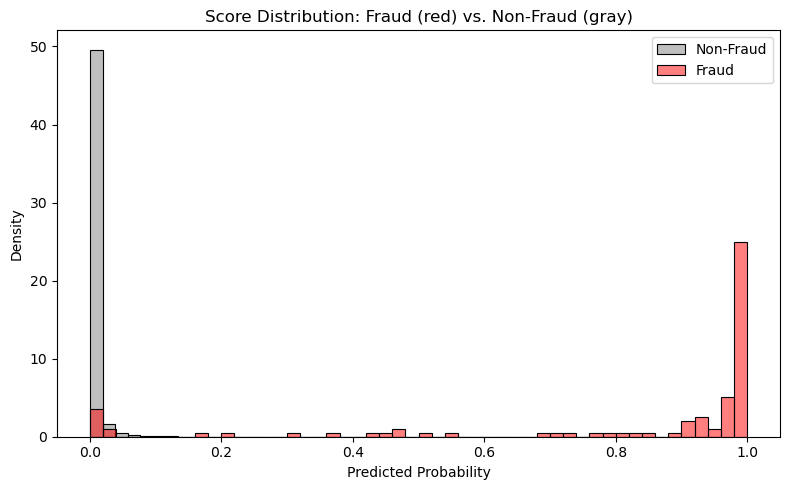

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

df_scores = pd.DataFrame({
    'y_true': y_true,
    'y_score': y_score
})

plt.figure(figsize=(8,5))
sns.histplot(
    df_scores[df_scores['y_true']==0]['y_score'], 
    bins=50, label='Non‐Fraud', color='gray', alpha=0.5, stat='density'
)
sns.histplot(
    df_scores[df_scores['y_true']==1]['y_score'], 
    bins=50, label='Fraud', color='red', alpha=0.5, stat='density'
)
plt.legend()
plt.title("Score Distribution: Fraud (red) vs. Non‐Fraud (gray)")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import classification_report, roc_auc_score

print("Test‐set Classification Report at threshold 0.5:")
print(classification_report(y_true, y_pred, digits=4))
print("Test ROC‐AUC:", roc_auc_score(y_true, y_score))

Test‐set Classification Report at threshold 0.5:
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8100    0.8265    0.8182        98

    accuracy                         0.9994     56962
   macro avg     0.9049    0.9131    0.9089     56962
weighted avg     0.9994    0.9994    0.9994     56962

Test ROC‐AUC: 0.9644232605112952


Top 20 by predicted score:
     y_true  y_score
0        1     1.00
1        1     1.00
2        1     1.00
3        1     1.00
4        1     1.00
..     ...      ...
95       0     0.54
96       1     0.51
97       0     0.50
98       0     0.50
99       0     0.50

[100 rows x 2 columns] 

Rows in top 0.3%: 170 (of 56962), frauds in that slice: 88



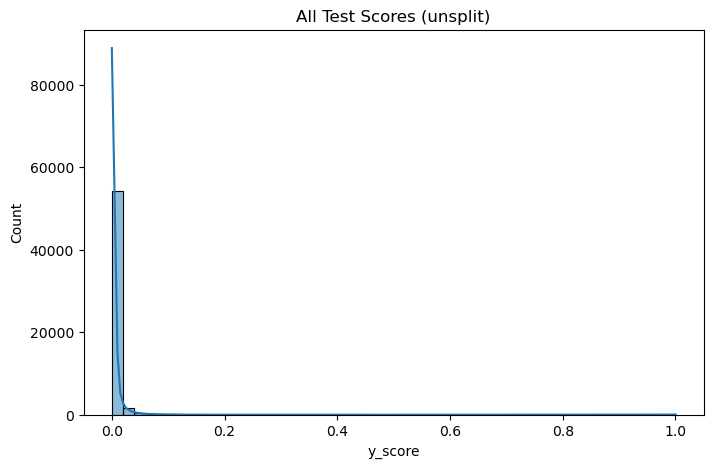

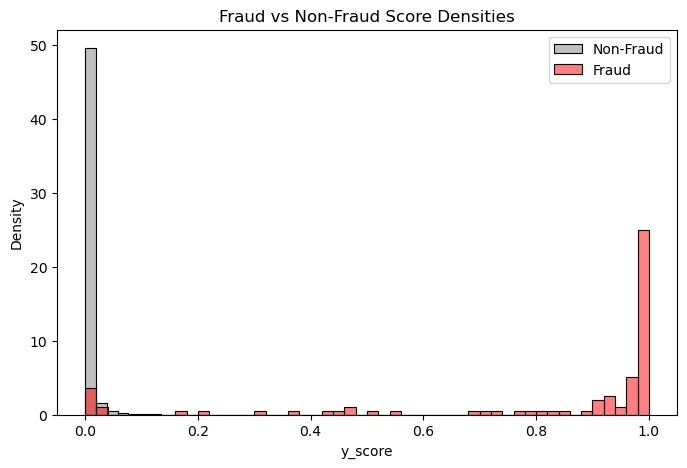

Classification report at 0.5‐threshold on test set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.83      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Test ROC‐AUC: 0.9644232605112952


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score

# 1) Peek at top‐20 scored rows:
df_top20 = (
    pd.DataFrame({'y_true': y_true, 'y_score': y_score})
      .sort_values('y_score', ascending=False)
      .reset_index(drop=True)
)
print("Top 20 by predicted score:\n", df_top20.head(100), "\n")

# 2) Check how many frauds you captured in the top 0.3%:
N = len(df_top20)
cutoff_index = int(0.003 * N)
num_frauds_in_top = df_top20.iloc[:cutoff_index]['y_true'].sum()
print(f"Rows in top 0.3%: {cutoff_index} (of {N}), frauds in that slice: {num_frauds_in_top}\n")

# 3) Plot separate histograms of scores by class:
plt.figure(figsize=(8,5))
sns.histplot(df_top20['y_score'], bins=50, kde=True)  # just to see full range
plt.title("All Test Scores (unsplit)"); plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df_top20[df_top20['y_true']==0]['y_score'], bins=50, label='Non‐Fraud', color='gray', alpha=0.5, stat='density')
sns.histplot(df_top20[df_top20['y_true']==1]['y_score'], bins=50, label='Fraud', color='red', alpha=0.5, stat='density')
plt.legend(); plt.title("Fraud vs Non‐Fraud Score Densities"); plt.show()

# 4) Compare test‐set metrics against CV metrics:
print("Classification report at 0.5‐threshold on test set:\n", classification_report(y_true, y_pred))
print("Test ROC‐AUC:", roc_auc_score(y_true, y_score))
